In [52]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
import matplotlib.pyplot as plt
import logging
import time
import tqdm
import mplfinance as mpf

In [5]:
from scipy.stats import binom_test

# Given values
successes = 17
trials = 29
p = 0.5  # Probability under the null hypothesis

# Perform the binomial test
p_value = binom_test(successes, trials, p, alternative='greater')
print(p_value)

0.22912915982306004


C:\Users\theis\AppData\Local\Temp\ipykernel_24204\807861307.py:9: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(successes, trials, p, alternative='greater')


Henter data

In [53]:
import requests
import pandas as pd
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='nasdaq_scraping.log', filemode='w')

def scrape_index_data(url):
    headers = {
        'Name': 'Theis Scheuer Jansen',
        'Email': 'Theisscheuerjansen@gmail.com',
        'User-Agent': 'Mozilla/5.0',
        'Referer': url,
        'Origin': 'https://www.nasdaqomxnordic.com'
    }

    try:
        # Make the request
        response = requests.get(url, headers=headers, timeout=30)
        time.sleep(1)  # Sleep to avoid overwhelming the server
        
        response.raise_for_status()  # Raise an error for bad status codes
        logging.info(f"Request successful for URL: {url}")
    except requests.RequestException as e:
        logging.error(f"Request failed for URL: {url}, Error: {e}")
        print(f"Request failed: {e}")
        return None

    # Extract the 'cp' (closing prices) data from the JSON response
    data = response.json()
    chart_data = data['data'][0]['chartData']['cp']

    # Convert to a pandas DataFrame
    df = pd.DataFrame(chart_data, columns=['Timestamp', 'Value'])

    # Convert the timestamp to a datetime object
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

    return df

# URLs for each index
urls = {
    'OMXdf': "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1980-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/visitolur/soguleg_gogn-HistoryChart&DefaultDecimals=false&Instrument=DK0016268840",
    'OMXH25': "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1980-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/index/index_info-HistoryChart&DefaultDecimals=false&Instrument=FI0008900212",
    'OMXS30': "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1980-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/indeks/historiske_priser-HistoryChart&DefaultDecimals=false&Instrument=SE0000337842"

    # Add URL for OBX if available
}

# Scrape data for each index
for index_name, index_url in urls.items():
    df = scrape_index_data(index_url)
    if df is not None:
        df.to_csv(f'{index_name}_historical_data.csv', index=False)
        print(f'{index_name} data saved to {index_name}_historical_data.csv')
    else:
        print(f'Failed to retrieve data for {index_name}')

print(df)

OMXdf data saved to OMXdf_historical_data.csv
OMXH25 data saved to OMXH25_historical_data.csv
OMXS30 data saved to OMXS30_historical_data.csv
      Timestamp    Value
0    1986-09-30   125.00
1    1986-10-01   125.93
2    1986-10-02   126.25
3    1986-10-03   126.68
4    1986-10-06   128.15
...         ...      ...
9485 2024-07-31  2609.33
9486 2024-08-05  2411.26
9487 2024-08-06  2402.96
9488 2024-08-07  2442.13
9489 2024-08-08  2450.39

[9490 rows x 2 columns]


Svensk data rens

In [54]:
# After loading the data and before setting the index, let's check the columns
print(df.columns)

# If 'Timestamp' is present, proceed with setting it as the index
if 'Timestamp' in df.columns:
    df.set_index('Timestamp', inplace=True)
else:
    print("Error: 'Timestamp' column is not present in the DataFrame.")
    
# Generate a complete date range from January 1, 1986, to August 8, 2024, including weekends
full_date_range = pd.date_range(start='1980-01-01', end='2024-08-08', freq='D')

# Reindex the DataFrame to include the full date range, filling in missing dates
df = df.reindex(full_date_range)

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()

# Reset the index to include 'Timestamp' as a column again
df.reset_index(inplace=True)
df.rename(columns={'index': 'Timestamp'}, inplace=True)

# Define election dates
election_dates = [
    '1985-09-15',
    '1988-09-18',
    '1991-09-15',
    '1994-09-18',
    '1998-09-20',
    '2002-09-15',
    '2006-09-17',
    '2010-09-19',
    '2014-09-14',
    '2018-09-09',
    '2022-09-11'
]

# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Add a new column 'Election' to indicate whether the row is an election date
df['Election'] = df['Timestamp'].isin(election_dates)

# Correct the periods list with valid date strings
periods = [
    ('1980-09-20', '1982-09-18', 'Blå'),  # Moderate Party
    ('1982-09-19', '1991-09-14', 'Rød'),  # Social Democrats
    ('1991-09-15', '1994-09-17', 'Blå'),  # Moderate Party
    ('1994-09-18', '2006-09-16', 'Rød'),  # Social Democrats
    ('2006-09-17', '2014-09-13', 'Blå'),  # Moderate Party
    ('2014-09-14', '2022-09-10', 'Rød'),  # Social Democrats
    ('2022-09-11', '2026-09-30', 'Blå')   # Moderate Party
]

# Convert all period date strings to datetime objects
periods = [(pd.to_datetime(start), pd.to_datetime(end), color) for start, end, color in periods]

# Assign "Rød" or "Blå" based on the defined periods
for start, end, color in periods:
    df.loc[(df['Timestamp'] >= start) & (df['Timestamp'] <= end), 'Color'] = color

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()


Index(['Timestamp', 'Value'], dtype='object')


Afkast udregning

In [55]:
# Rename the DataFrame from df to data
data = df

# Ensure 'Timestamp' is set as the index for proper time series operations
data.set_index('Timestamp', inplace=True)

# Resample the data to get the last closing price of each month
monthly_data = data['Value'].resample('M').last()

# Calculate the monthly returns
data['Monthly Return'] = monthly_data.pct_change()

# Calculate direct returns for 1, 3, 6, 9, and 12 months before each election date
data['Return_3M'] = pd.NA
data['Return_6M'] = pd.NA
data['Return_9M'] = pd.NA
data['Return_12M'] = pd.NA

for date in election_dates:
    if date in data.index:
        data.loc[date, 'Return_3M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=3), 'Value'] - 1) * 100
        data.loc[date, 'Return_6M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=6), 'Value'] - 1) * 100
        data.loc[date, 'Return_9M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=9), 'Value'] - 1) * 100
        data.loc[date, 'Return_12M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=12), 'Value'] - 1) * 100

# Reset the index to include 'Timestamp' as a column again
data.reset_index(inplace=True)

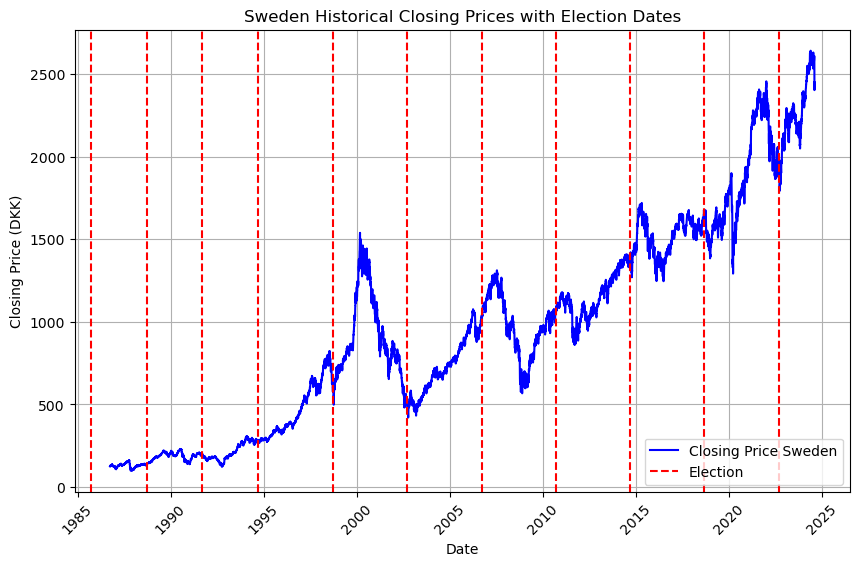

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Swedish election dates
election_dates = [
    '1985-09-15',
    '1988-09-18',
    '1991-09-15',
    '1994-09-18',
    '1998-09-20',
    '2002-09-15',
    '2006-09-17',
    '2010-09-19',
    '2014-09-14',
    '2018-09-09',
    '2022-09-11'
]

# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Filter the data to start from 01/01/2015
start_date = pd.to_datetime('1980-01-01')
df_filtered = df[df['Timestamp'] >= start_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['Timestamp'], df_filtered['Value'], label='Closing Price Sweden', color='blue')

# Plot vertical lines for the election dates
for election_date in election_dates:
    plt.axvline(x=election_date, color='red', linestyle='--', label='Election' if election_date == election_dates[0] else "")

# Adding titles and labels
plt.title('Sweden Historical Closing Prices with Election Dates')
plt.xlabel('Date')
plt.ylabel('Closing Price (DKK)')

# Formatting the date on the x-axis for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [57]:
# Filtrer DataFrame for kun at inkludere rækker, hvor 'Election' er True
election_data = data[data['Election']]

# Juster displayindstillingerne
pd.set_option('display.max_columns', None)  # Vis alle kolonner
pd.set_option('display.expand_frame_repr', False)  # Forhindr brud på linjer
pd.set_option('display.max_colwidth', None)  # Vis fulde kolonnebredder

# Udskriv DataFrame
display(election_data)

# Eksporter til Excel
election_data.to_excel('election_data.xlsx', index=False)


,Timestamp,Value,Election,Color,Monthly Return,Return_3M,Return_6M,Return_9M,Return_12M
2084,1985-09-15,NaN,True,Rød,NaN,NaN,NaN,NaN,NaN
3183,1988-09-18,136.54,True,Rød,NaN,-0.575257,4.014626,27.643264,-11.676046
4275,1991-09-15,200.36,True,Blå,NaN,-0.46202,1.023547,29.347966,5.419341
5374,1994-09-18,282.06,True,Rød,NaN,3.98142,-2.215289,6.013681,14.7005
6837,1998-09-20,584.05,True,Rød,NaN,-21.586134,-19.959161,1.820052,-7.07683
8293,2002-09-15,511.80,True,Rød,NaN,-16.061207,-36.246543,-37.575469,-26.414769
9756,2006-09-17,1025.47,True,Blå,NaN,12.715022,-0.830706,8.679801,17.541809
11219,2010-09-19,1081.98,True,Blå,NaN,2.598191,6.049438,15.592449,17.577127
12675,2014-09-14,1388.59,True,Rød,NaN,-0.112218,4.655492,10.582061,9.685854
14131,2018-09-09,1618.20,True,Rød,NaN,4.006119,1.797914,0.458152,4.24397


Finsk

In [58]:
import requests
import pandas as pd
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='nasdaq_scraping.log', filemode='w')

def scrape_index_data(url):
    headers = {
        'Name': 'Theis Scheuer Jansen',
        'Email': 'Theisscheuerjansen@gmail.com',
        'User-Agent': 'Mozilla/5.0',
        'Referer': url,
        'Origin': 'https://www.nasdaqomxnordic.com'
    }

    try:
        # Make the request
        response = requests.get(url, headers=headers, timeout=30)
        time.sleep(1)  # Sleep to avoid overwhelming the server
        
        response.raise_for_status()  # Raise an error for bad status codes
        logging.info(f"Request successful for URL: {url}")
    except requests.RequestException as e:
        logging.error(f"Request failed for URL: {url}, Error: {e}")
        print(f"Request failed: {e}")
        return None

    # Extract the 'cp' (closing prices) data from the JSON response
    data = response.json()
    chart_data = data['data'][0]['chartData']['cp']

    # Convert to a pandas DataFrame
    df = pd.DataFrame(chart_data, columns=['Timestamp', 'Value'])

    # Convert the timestamp to a datetime object
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

    return df

# URLs for each index
urls = {
    'OMXH25': "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1980-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/index/index_info-HistoryChart&DefaultDecimals=false&Instrument=FI0008900212"
}

# Scrape data for each index
for index_name, index_url in urls.items():
    df = scrape_index_data(index_url)
    if df is not None:
        df.to_csv(f'{index_name}_historical_data.csv', index=False)
        print(f'{index_name} data saved to {index_name}_historical_data.csv')
    else:
        print(f'Failed to retrieve data for {index_name}')

# After loading the data and before setting the index, let's check the columns
print(df.columns)

# If 'Timestamp' is present, proceed with setting it as the index
if 'Timestamp' in df.columns:
    df.set_index('Timestamp', inplace=True)
else:
    print("Error: 'Timestamp' column is not present in the DataFrame.")
    
# Generate a complete date range from January 1, 1980, to August 8, 2024, including weekends
full_date_range = pd.date_range(start='1980-01-01', end='2024-08-08', freq='D')

# Reindex the DataFrame to include the full date range, filling in missing dates
df = df.reindex(full_date_range)

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()

# Reset the index to include 'Timestamp' as a column again
df.reset_index(inplace=True)
df.rename(columns={'index': 'Timestamp'}, inplace=True)

# Define Finnish election dates
election_dates = [
    '1987-03-15',
    '1991-03-17',
    '1995-03-19',
    '1999-03-21',
    '2003-03-16',
    '2007-03-18',
    '2011-04-17',
    '2015-04-19',
    '2019-04-14',
    '2023-04-02'
]

# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Add a new column 'Election' to indicate whether the row is an election date
df['Election'] = df['Timestamp'].isin(election_dates)

# Define the winning parties (corrected to match Finnish political colors)
periods = [
    ('1987-03-15', '1991-03-16', 'Blå'),  # Coalition Party (Kokoomus)
    ('1991-03-17', '1995-03-18', 'Blå'),  # Coalition Party (Kokoomus)
    ('1995-03-19', '2003-03-15', 'Rød'),  # Social Democrats
    ('2003-03-16', '2007-03-17', 'Rød'),  # Social Democrats
    ('2007-03-18', '2011-04-16', 'Blå'),  # Coalition Party (Kokoomus)
    ('2011-04-17', '2019-04-13', 'Rød'),  # Social Democrats
    ('2019-04-14', '2023-04-01', 'Rød'),  # Social Democrats
    ('2023-04-02', '2027-04-01', 'Blå')   # Coalition Party (Kokoomus)
]


# Convert all period date strings to datetime objects
periods = [(pd.to_datetime(start), pd.to_datetime(end), color) for start, end, color in periods]

# Assign "Rød" or "Blå" based on the defined periods
for start, end, color in periods:
    df.loc[(df['Timestamp'] >= start) & (df['Timestamp'] <= end), 'Color'] = color

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()


OMXH25 data saved to OMXH25_historical_data.csv
Index(['Timestamp', 'Value'], dtype='object')


In [59]:
# Rename the DataFrame from df to data
data = df

# Ensure 'Timestamp' is set as the index for proper time series operations
data.set_index('Timestamp', inplace=True)

# Resample the data to get the last closing price of each month
monthly_data = data['Value'].resample('M').last()

# Calculate the monthly returns
data['Monthly Return'] = monthly_data.pct_change()

# Calculate direct returns for 1, 3, 6, 9, and 12 months before each election date
data['Return_3M'] = pd.NA
data['Return_6M'] = pd.NA
data['Return_9M'] = pd.NA
data['Return_12M'] = pd.NA

for date in election_dates:
    if date in data.index:
        data.loc[date, 'Return_3M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=3), 'Value'] - 1) * 100
        data.loc[date, 'Return_6M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=6), 'Value'] - 1) * 100
        data.loc[date, 'Return_9M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=9), 'Value'] - 1) * 100
        data.loc[date, 'Return_12M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=12), 'Value'] - 1) * 100

# Reset the index to include 'Timestamp' as a column again
data.reset_index(inplace=True)

OMXH25 data saved to OMXH25_historical_data.csv
Index(['Timestamp', 'Value'], dtype='object')


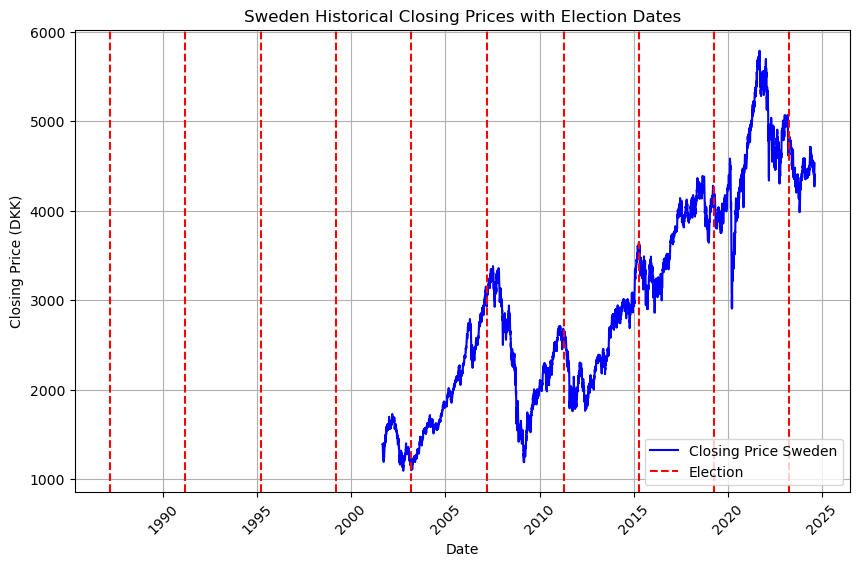

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

import requests
import pandas as pd
import logging
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='nasdaq_scraping.log', filemode='w')

def scrape_index_data(url):
    headers = {
        'Name': 'Theis Scheuer Jansen',
        'Email': 'Theisscheuerjansen@gmail.com',
        'User-Agent': 'Mozilla/5.0',
        'Referer': url,
        'Origin': 'https://www.nasdaqomxnordic.com'
    }

    try:
        # Make the request
        response = requests.get(url, headers=headers, timeout=30)
        time.sleep(1)  # Sleep to avoid overwhelming the server
        
        response.raise_for_status()  # Raise an error for bad status codes
        logging.info(f"Request successful for URL: {url}")
    except requests.RequestException as e:
        logging.error(f"Request failed for URL: {url}, Error: {e}")
        print(f"Request failed: {e}")
        return None

    # Extract the 'cp' (closing prices) data from the JSON response
    data = response.json()
    chart_data = data['data'][0]['chartData']['cp']

    # Convert to a pandas DataFrame
    df = pd.DataFrame(chart_data, columns=['Timestamp', 'Value'])

    # Convert the timestamp to a datetime object
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

    return df

# URLs for each index
urls = {
    'OMXH25': "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1980-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/index/index_info-HistoryChart&DefaultDecimals=false&Instrument=FI0008900212"
}

# Scrape data for each index
for index_name, index_url in urls.items():
    df = scrape_index_data(index_url)
    if df is not None:
        df.to_csv(f'{index_name}_historical_data.csv', index=False)
        print(f'{index_name} data saved to {index_name}_historical_data.csv')
    else:
        print(f'Failed to retrieve data for {index_name}')

# After loading the data and before setting the index, let's check the columns
print(df.columns)

# If 'Timestamp' is present, proceed with setting it as the index
if 'Timestamp' in df.columns:
    df.set_index('Timestamp', inplace=True)
else:
    print("Error: 'Timestamp' column is not present in the DataFrame.")
    
# Generate a complete date range from January 1, 1980, to August 8, 2024, including weekends
full_date_range = pd.date_range(start='2000-01-01', end='2024-08-08', freq='D')

# Reindex the DataFrame to include the full date range, filling in missing dates
df = df.reindex(full_date_range)

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()

# Reset the index to include 'Timestamp' as a column again
df.reset_index(inplace=True)
df.rename(columns={'index': 'Timestamp'}, inplace=True)

# Define Finnish election dates
election_dates = [
    '1987-03-15',
    '1991-03-17',
    '1995-03-19',
    '1999-03-21',
    '2003-03-16',
    '2007-03-18',
    '2011-04-17',
    '2015-04-19',
    '2019-04-14',
    '2023-04-02'
]

# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Add a new column 'Election' to indicate whether the row is an election date
df['Election'] = df['Timestamp'].isin(election_dates)

# Define the winning parties (corrected to match Finnish political colors)
periods = [
    ('1987-03-15', '1991-03-16', 'Blå'),  # Coalition Party (Kokoomus)
    ('1991-03-17', '1995-03-18', 'Blå'),  # Coalition Party (Kokoomus)
    ('1995-03-19', '2003-03-15', 'Rød'),  # Social Democrats
    ('2003-03-16', '2007-03-17', 'Rød'),  # Social Democrats
    ('2007-03-18', '2011-04-16', 'Blå'),  # Coalition Party (Kokoomus)
    ('2011-04-17', '2019-04-13', 'Rød'),  # Social Democrats
    ('2019-04-14', '2023-04-01', 'Rød'),  # Social Democrats
    ('2023-04-02', '2027-04-01', 'Blå')   # Coalition Party (Kokoomus)
]


# Convert all period date strings to datetime objects
periods = [(pd.to_datetime(start), pd.to_datetime(end), color) for start, end, color in periods]

# Assign "Rød" or "Blå" based on the defined periods
for start, end, color in periods:
    df.loc[(df['Timestamp'] >= start) & (df['Timestamp'] <= end), 'Color'] = color

# Forward fill missing data to handle weekends and holidays
df['Value'] = df['Value'].ffill()


# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Filter the data to start from 01/01/2015
start_date = pd.to_datetime('1980-01-01')
df_filtered = df[df['Timestamp'] >= start_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['Timestamp'], df_filtered['Value'], label='Closing Price Sweden', color='blue')

# Plot vertical lines for the election dates
for election_date in election_dates:
    plt.axvline(x=election_date, color='red', linestyle='--', label='Election' if election_date == election_dates[0] else "")

# Adding titles and labels
plt.title('Sweden Historical Closing Prices with Election Dates')
plt.xlabel('Date')
plt.ylabel('Closing Price (DKK)')

# Formatting the date on the x-axis for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [61]:
# Filtrer DataFrame for kun at inkludere rækker, hvor 'Election' er True
election_data = data[data['Election']]

# Juster displayindstillingerne
pd.set_option('display.max_columns', None)  # Vis alle kolonner
pd.set_option('display.expand_frame_repr', False)  # Forhindr brud på linjer
pd.set_option('display.max_colwidth', None)  # Vis fulde kolonnebredder

# Udskriv DataFrame
display(election_data)

# Eksporter til Excel
election_data.to_excel('election_data.xlsx', index=False)


,Timestamp,Value,Election,Color,Monthly Return,Return_3M,Return_6M,Return_9M,Return_12M
2630,1987-03-15,NaN,True,Blå,NaN,NaN,NaN,NaN,NaN
4093,1991-03-17,NaN,True,Blå,NaN,NaN,NaN,NaN,NaN
5556,1995-03-19,NaN,True,Rød,NaN,NaN,NaN,NaN,NaN
7019,1999-03-21,NaN,True,Rød,NaN,NaN,NaN,NaN,NaN
8475,2003-03-16,1160.51,True,Rød,NaN,-11.035218,-7.710721,-20.244796,-30.886233
9938,2007-03-18,3006.00,True,Blå,NaN,3.251424,17.477861,30.347115,10.587075
11429,2011-04-17,2594.15,True,Rød,NaN,-3.020617,5.88886,21.450107,15.57602
12892,2015-04-19,3551.66,True,Rød,NaN,14.221853,27.917681,20.794079,27.346198
14348,2019-04-14,4187.86,True,Rød,NaN,8.10868,5.083997,-0.084697,4.132104
15797,2023-04-02,4777.66,True,Blå,NaN,-2.834435,9.019756,5.351756,-2.791336
